# Module 2.4: SNN-MPR Comparison


New data frame to 
- merge optimized_amplitude and rand_init files wrt target frequencies
- save the full parameter set
- save the full optimization information
- save error (MPR frequency - SNN frequency)/target_frequency *100


SNN files are available at 

https://www.dropbox.com/scl/fo/vv7lx16wdb3tcnn125ar2/ACWugwhwcVYstGZ81TcVIWQ?rlkey=xo57pfu62afvy75ts7makyr11&e=1&st=3x9bk27n&dl=0

Until 16/02/2026 MPR files are available at 

https://filesender.renater.fr/?s=download&token=5a124153-45f2-429d-8732-79e867588592

## 0.1 Import all built-in packages.

In [15]:
# Import necessary packages
# %matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
import pickle
import zipfile
import seaborn as sns
from pathlib import Path


In [16]:
### Compute Power Spectrum of simulated MPR, output data.

def compute_PS_MPR(sol):
    dt_min = np.min(np.diff(sol.t))
    Fs = int(1000 / np.min(np.diff(sol.t)))
    sampling_rate_max = 1 / dt_min             # maximum sampling frequency (Hz)
    t_regular = np.arange(0, sol.t[-1], dt_min)
    y_regular = sol.sol(t_regular)
    # # Compute the Fourier Transform of the signal R_E
    sign = y_regular[0, int((t_regular[-1]-1000)/dt_min):int(t_regular[-1]/dt_min)]
    fft_values = np.fft.fft(sign)
    # # Compute the Power Spectrum (Magnitude squared of FFT)
    power_spectrum = np.abs(fft_values) ** 2
    # # Create the frequency axis
    frequencies = np.fft.fftfreq(len(sign), 1 / Fs)
    # Only keep the positive frequencies (due to symmetry)
    positive_freq_indices = frequencies > 0
    frequencies_exc = frequencies[positive_freq_indices]
    power_spectrum_exc = power_spectrum[positive_freq_indices]

    # # Compute the Fourier Transform of the signal R_I
    sign = y_regular[0, int((t_regular[-1]-1000)/dt_min):int(t_regular[-1]/dt_min)]
    fft_values = np.fft.fft(sign)
    # # Compute the Power Spectrum (Magnitude squared of FFT)
    power_spectrum = np.abs(fft_values) ** 2
    # # Create the frequency axis
    frequencies = np.fft.fftfreq(len(sign), 1 / Fs)
    # Only keep the positive frequencies (due to symmetry)
    positive_freq_indices = frequencies > 0
    frequencies_inh = frequencies[positive_freq_indices]
    power_spectrum_inh = power_spectrum[positive_freq_indices]

    return frequencies_exc, frequencies_inh, power_spectrum_exc, power_spectrum_inh

def compute_PS_SNN(data_SNN, cutoff_max_freq = 200):

    # get the frequency and power spectrum data
    freq_SNN_exc = data_SNN['fw_exc'][0:cutoff_max_freq]
    freq_SNN_inh = data_SNN['fw_inh'][0:cutoff_max_freq]

    PS_SNN_exc = data_SNN['fA_exc'][0:cutoff_max_freq]
    PS_SNN_inh = data_SNN['fA_inh'][0:cutoff_max_freq]

    PS_SNN_exc_scaled = PS_SNN_exc - np.min(PS_SNN_exc)
    PS_SNN_exc_scaled /= np.max(PS_SNN_exc_scaled)

    PS_SNN_inh_scaled = PS_SNN_inh - np.min(PS_SNN_inh)
    PS_SNN_inh_scaled /= np.max(PS_SNN_inh_scaled)

    return freq_SNN_exc, freq_SNN_inh, PS_SNN_exc_scaled, PS_SNN_inh_scaled


### Find Peaks of Power Spectrum 
def find_peaks_PS(frequencies, power_spectrum, target_freq, isitrange=True):
    if not isitrange:
        peak_frequencies = frequencies[np.argmax(power_spectrum)]
        return peak_frequencies
    else:
        ### compute the error between the target frequency and the peak frequency
        peak_frequencies = frequencies[np.argmax(power_spectrum)]

        ### compute the error in the range of the target frequency
        # Find all local maxima first
        vmin, vmax = target_freq *0, target_freq*1.90

        peaks = find_peaks(power_spectrum)

        # Filter by value range
        mask = (frequencies[peaks[0]] >= vmin) & (frequencies[peaks[0]] <= vmax)
        filtered_peaks = peaks[0][mask]
        if len(filtered_peaks) > 0:
            peak_frequencies = frequencies[filtered_peaks[np.argmax(power_spectrum[filtered_peaks])]]
        else:
            peak_frequencies = 0.0  # or some other default value if no peaks found in range

    return peak_frequencies

# 1.2 Read data, compute error, define the list

SNN Found 1 zip files for target frequency 60 Hz.
[PosixPath('/Users/koksal/Documents/Projects/2024_EITN/followup/codes/MPR-SNN_Data_Validation/Raw_SNN_from_rand_init_optimization_results/SNN_Data_Directory_Target_60_20260122234631.zip')]
MPR Found 1 zip files for target frequency 60 Hz.
[PosixPath('/Users/koksal/Documents/Projects/2024_EITN/followup/codes/MPR-SNN_Data_Validation/Raw_MPR_from_rand_init_optimization_results/MPR_Data_Directory_Target_60.zip')]


/var/folders/ph/5fwwdh2j3wl9wdm1flq7t5t8t0nvlj/T/ipykernel_6842/3723113077.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(ncols=2 ,nrows=1, sharex=True, figsize = (10, 6))


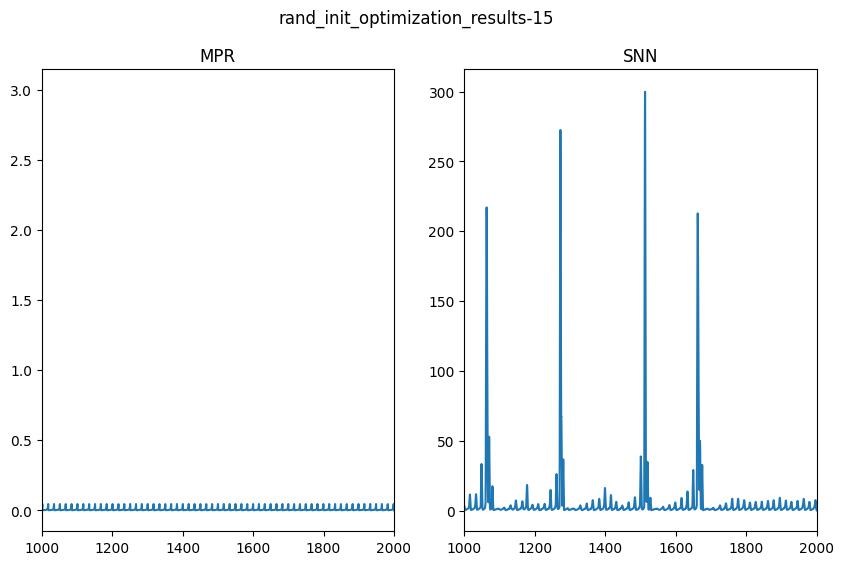

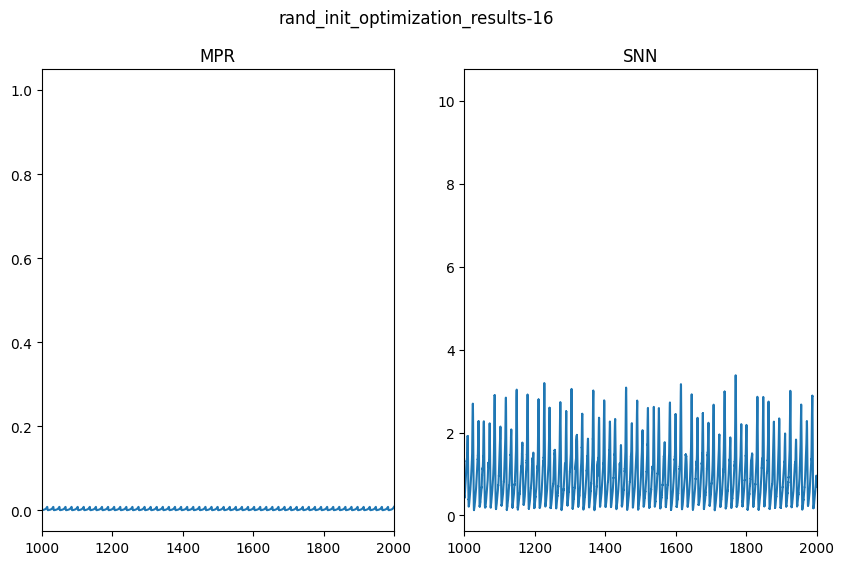

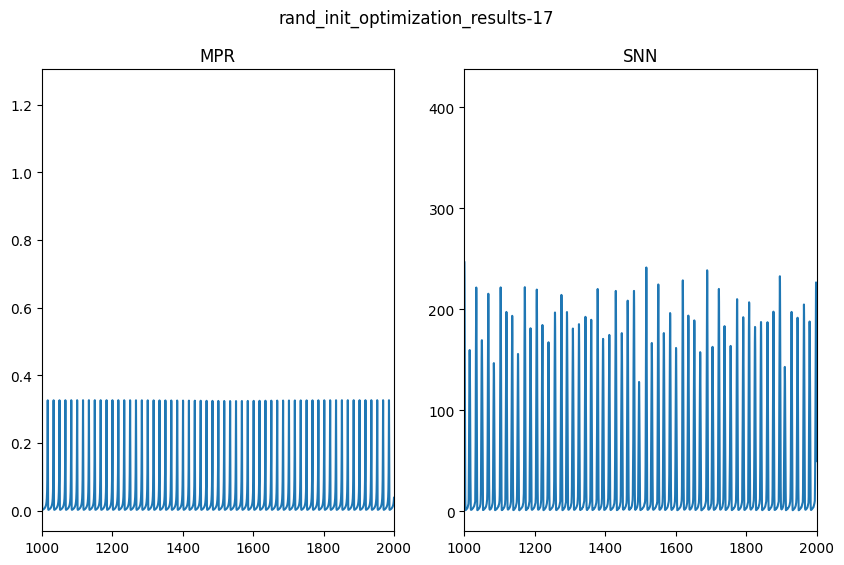

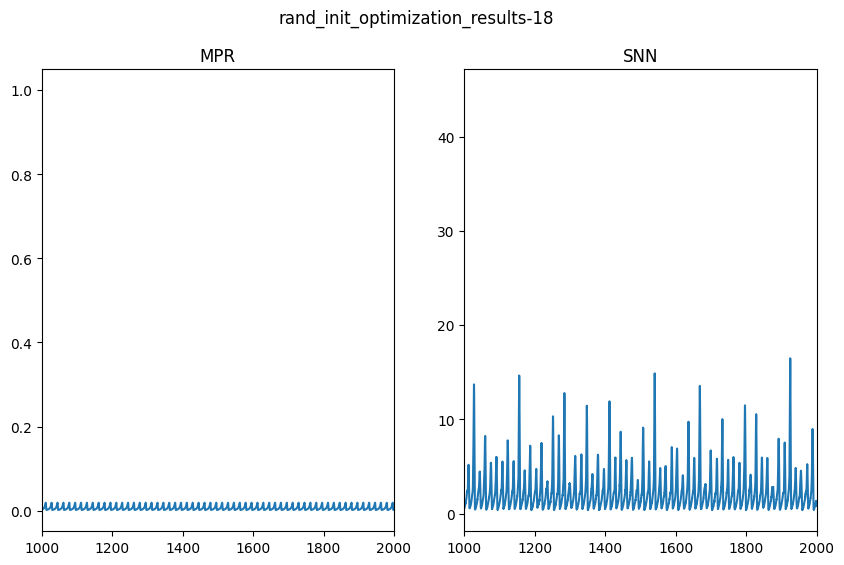

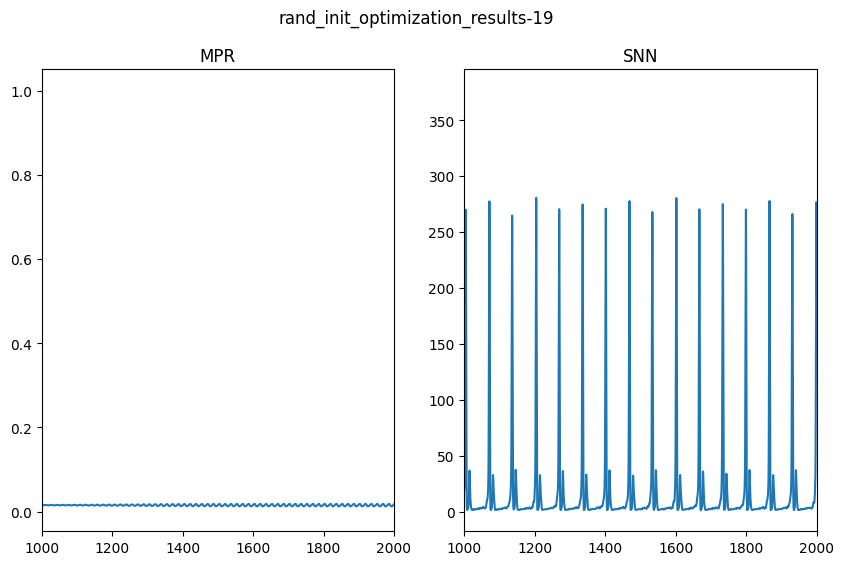

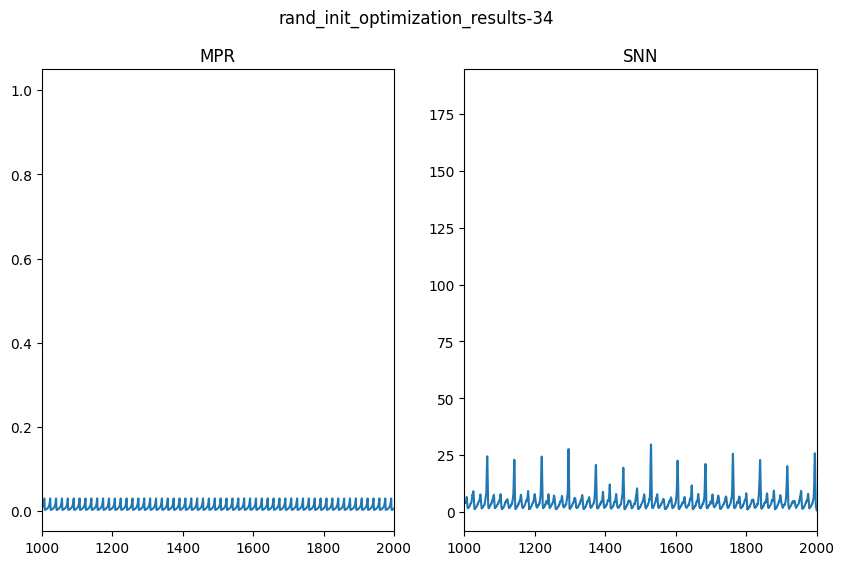

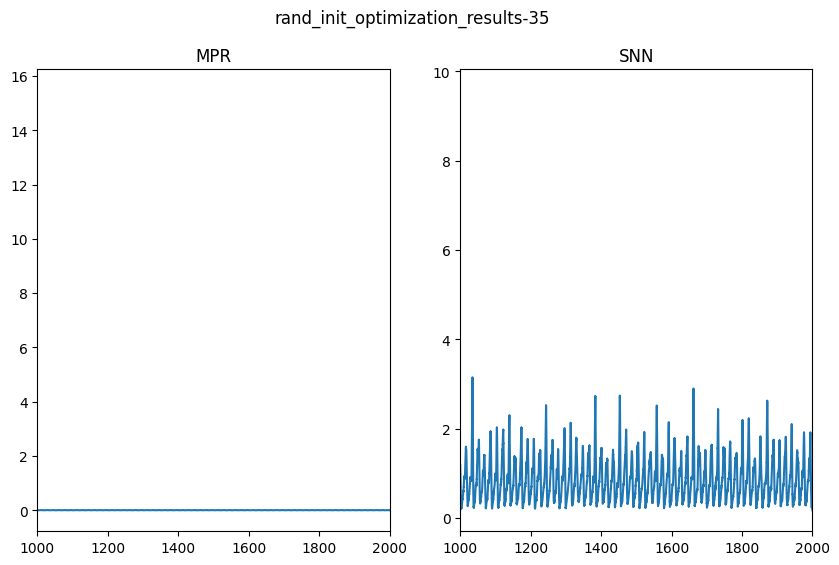

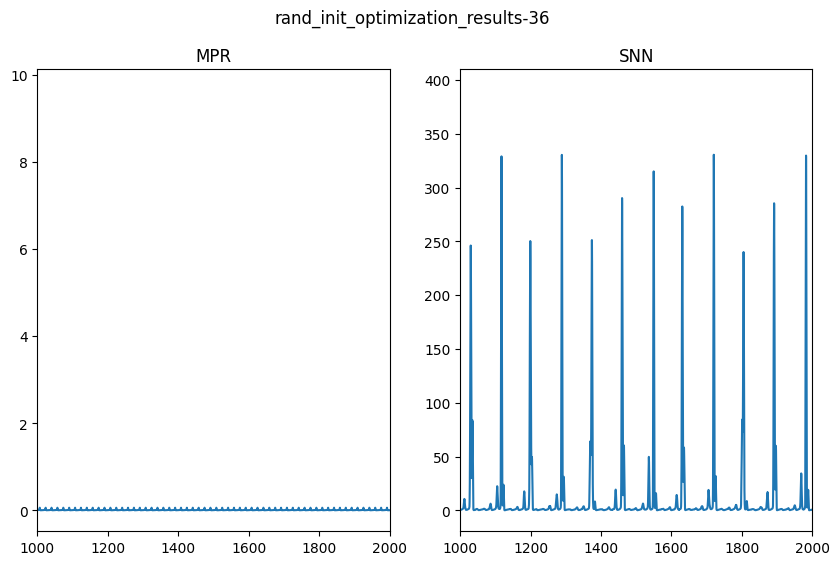

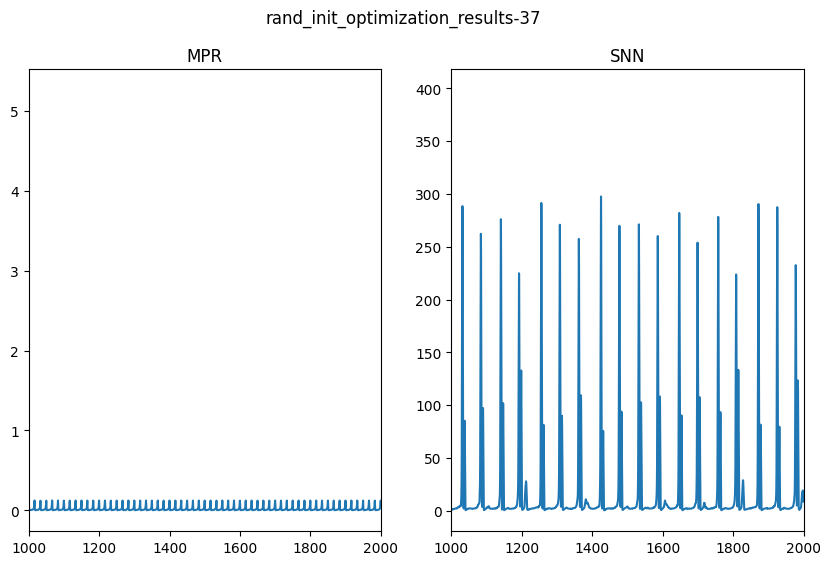

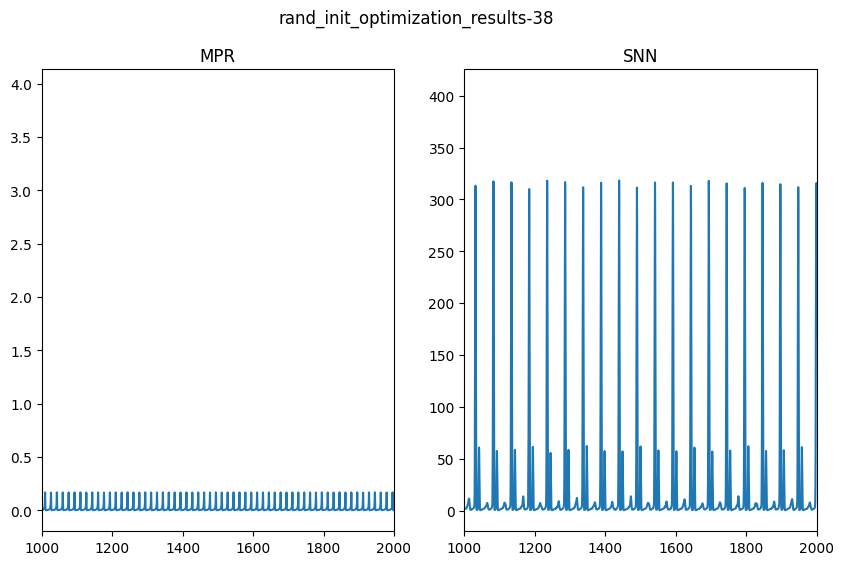

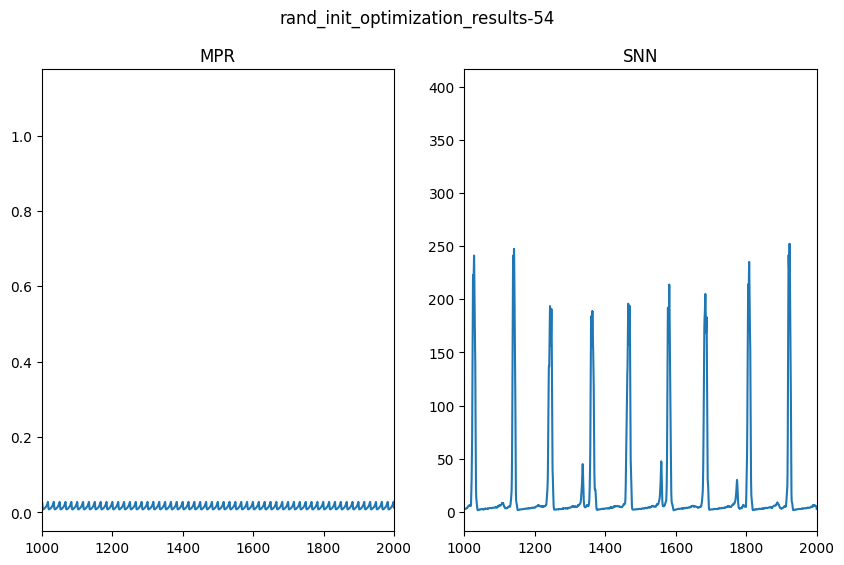

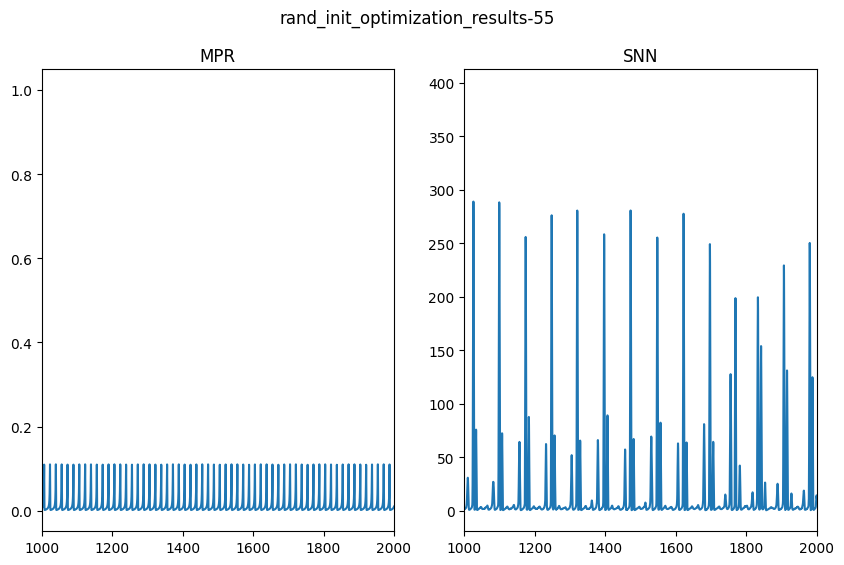

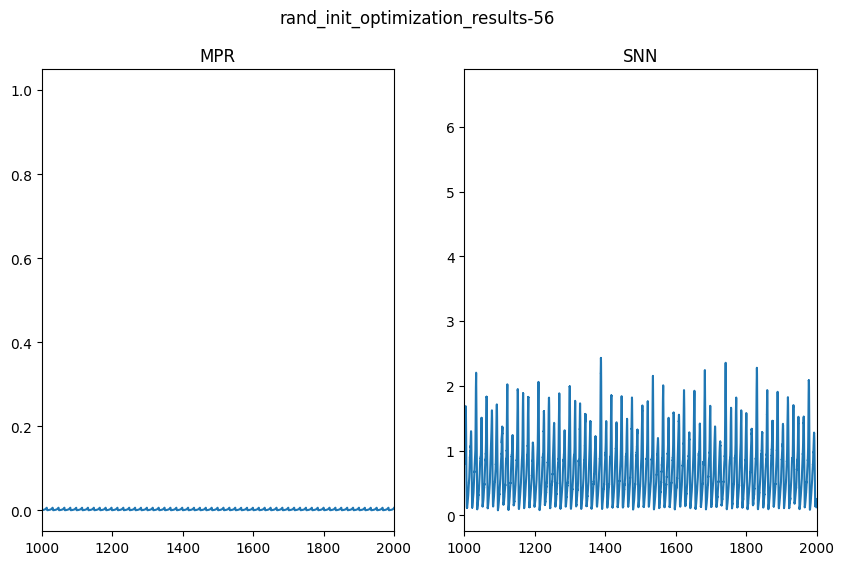

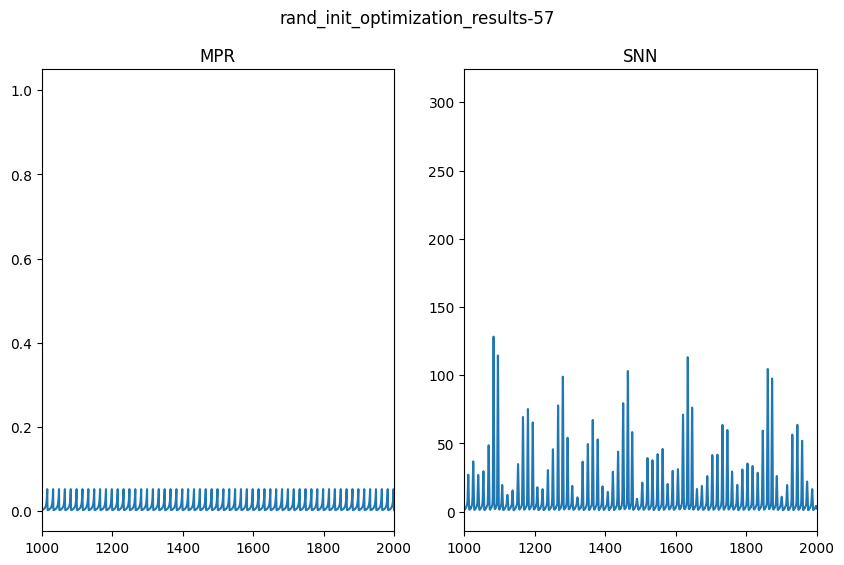

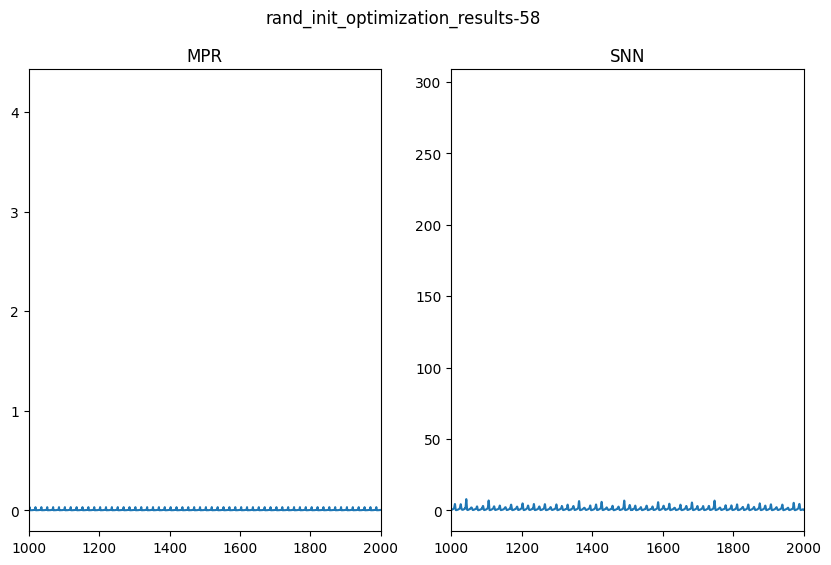

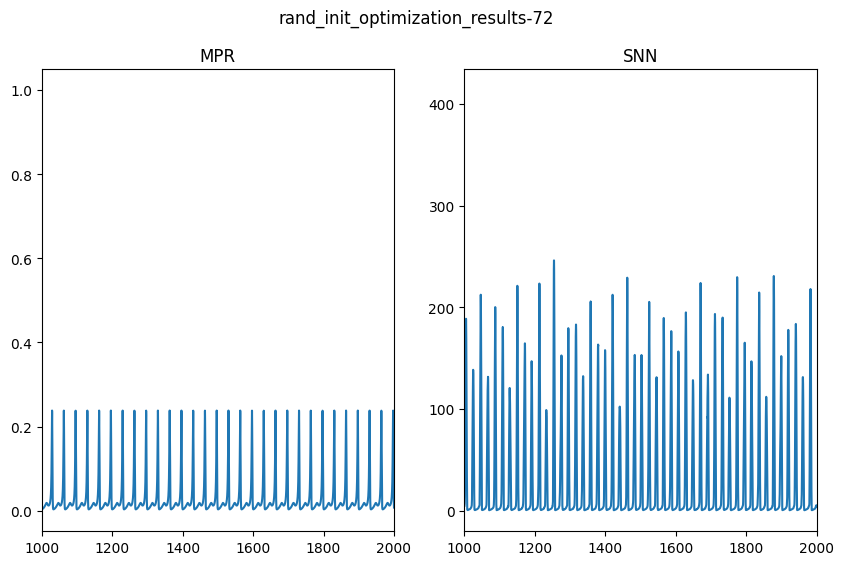

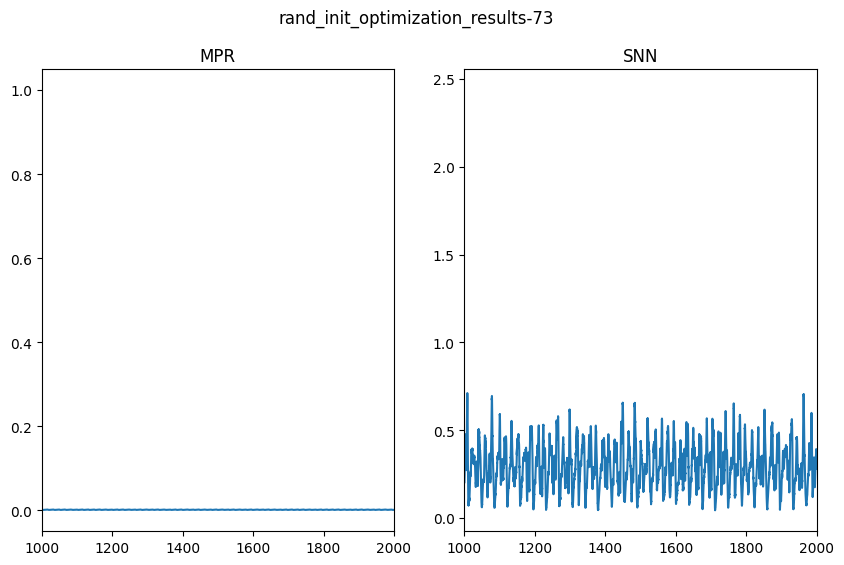

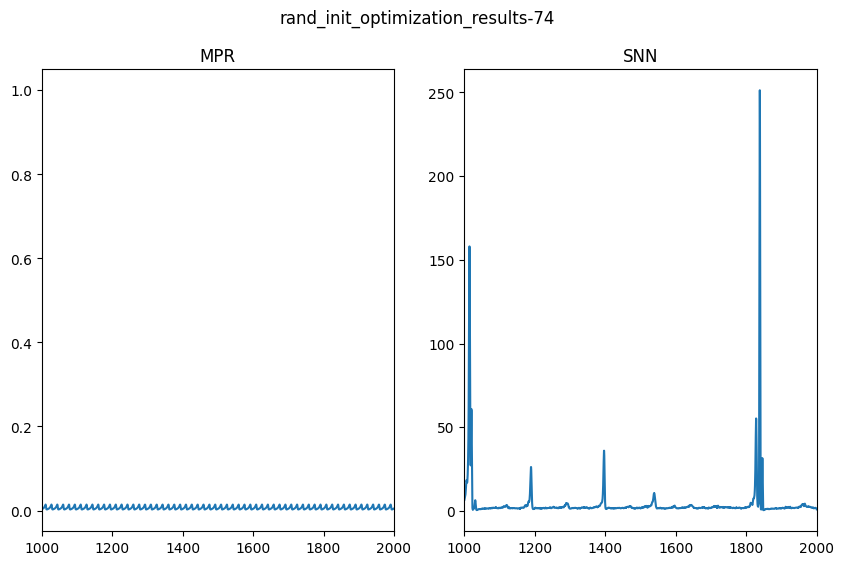

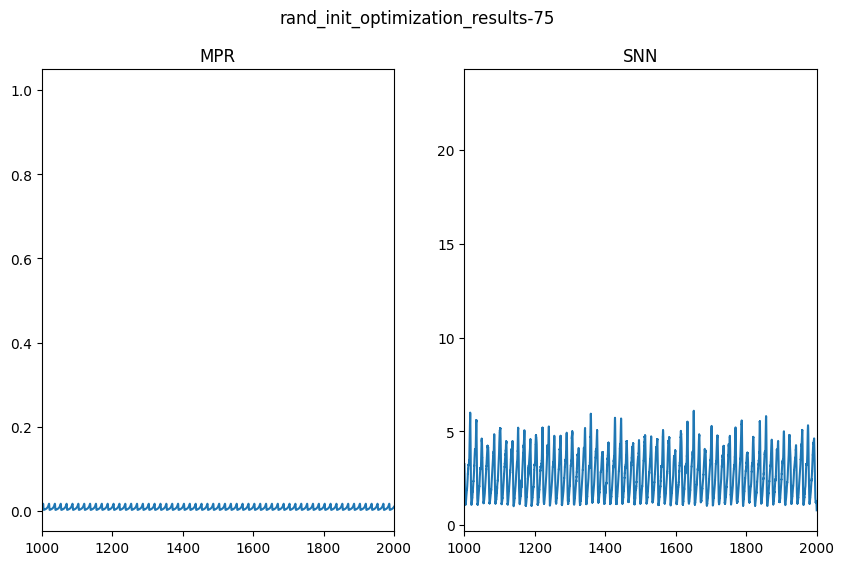

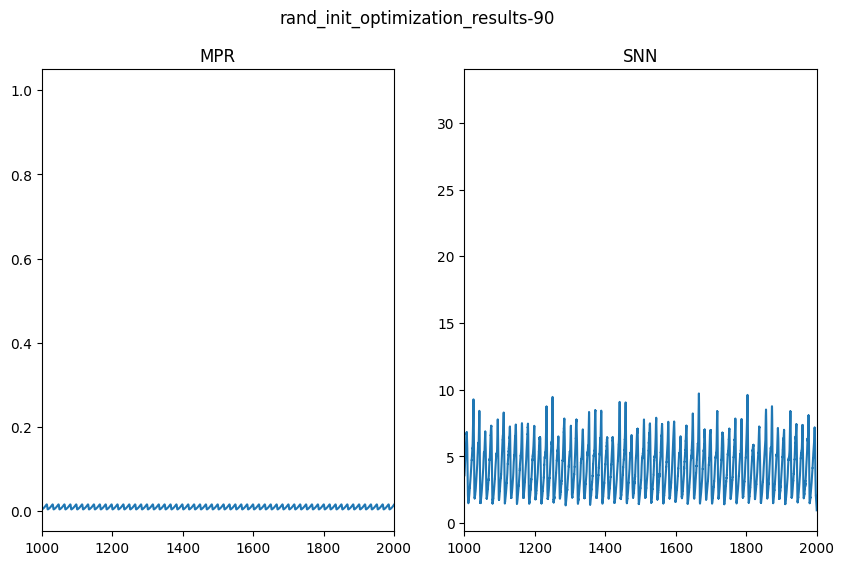

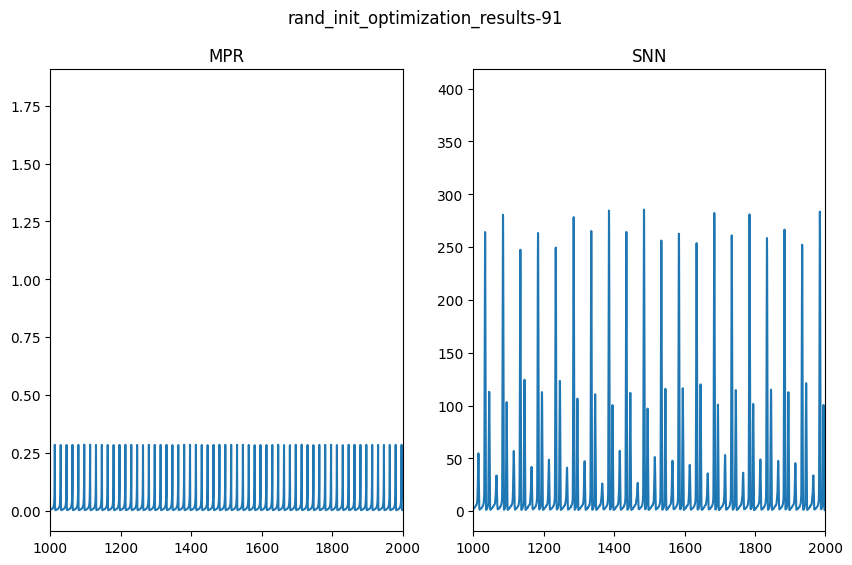

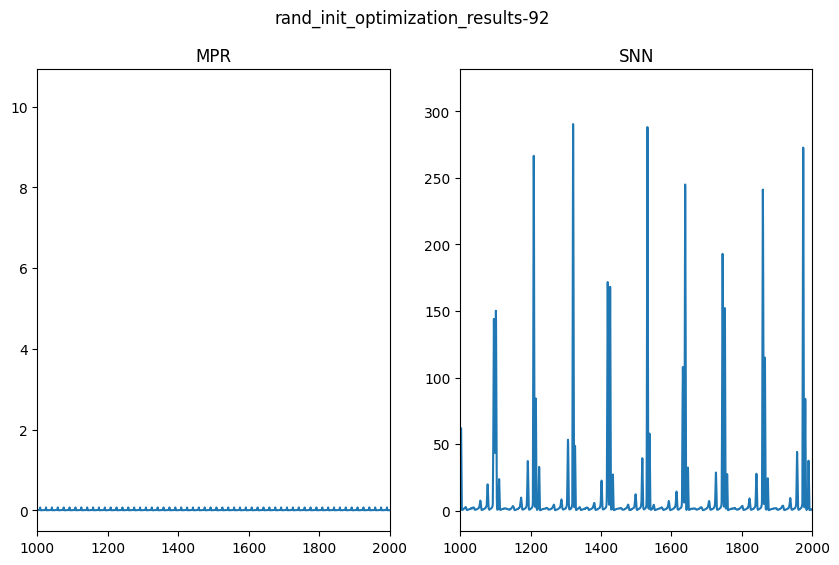

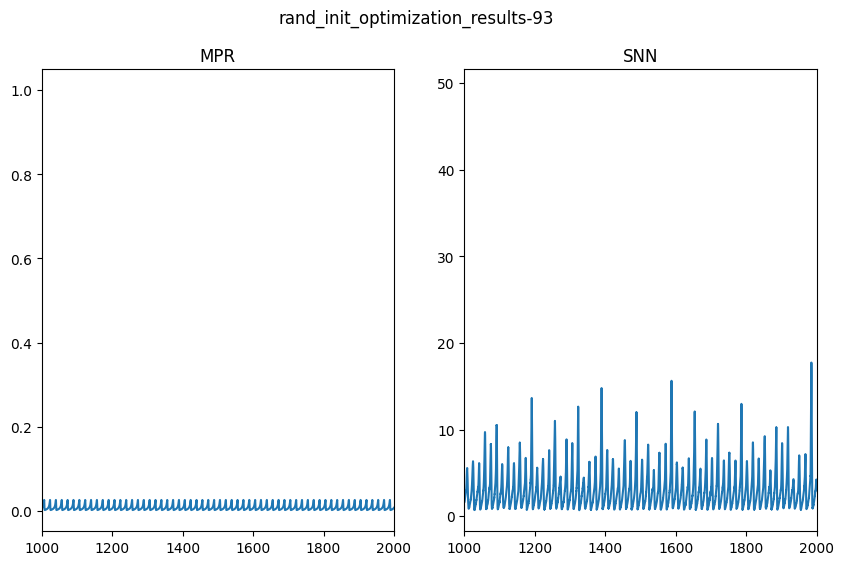

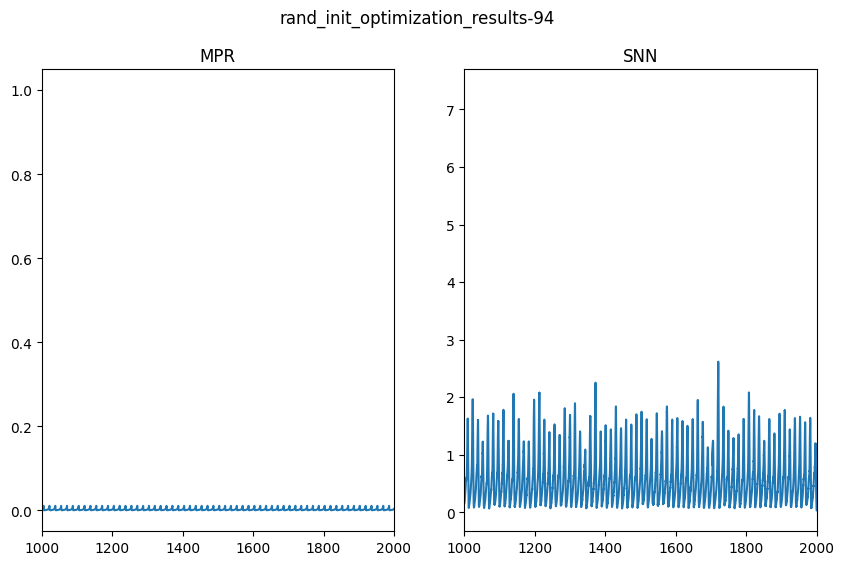

In [19]:
target_freq = 60 # Target frequency in Hz
from pathlib import PurePosixPath
import re

def _numeric_suffix_key(fname: str):
    m = re.search(r'(\d+)(?=\.pkl$)', fname)
    return int(m.group(1)) if m else float('inf')
# 'optimized_frequencies', 
for parameter_set_file in ['rand_init_optimization_results']:

    data_parameter_set = pd.read_csv(parameter_set_file + '.csv')

    # path to SNN
    zip_path = Path('/Users/koksal/Documents/Projects/2024_EITN/followup/codes/MPR-SNN_Data_Validation/Raw_SNN_from_'+parameter_set_file)
    zip_files = list(zip_path.glob("*.zip"))
    # group the ones starting with SNN_Data_Directory_Target+str(target_freq)
    zip_files_target = [z for z in zip_files if f'SNN_Data_Directory_Target_{target_freq}' in z.name]
    print(f"SNN Found {len(zip_files_target)} zip files for target frequency {target_freq} Hz.")
    print(zip_files_target)

    # path to MPR
    zip_path_MPR = Path('/Users/koksal/Documents/Projects/2024_EITN/followup/codes/MPR-SNN_Data_Validation/Raw_MPR_from_'+parameter_set_file)
    zip_files_MPR = list(zip_path_MPR.glob("*.zip"))
    zip_files_MPR_target = [z for z in zip_files_MPR if f'MPR_Data_Directory_Target_{target_freq}' in z.name]
    print(f"MPR Found {len(zip_files_MPR_target)} zip files for target frequency {target_freq} Hz.")
    print(zip_files_MPR_target)
    
    # # Open the zip file
    with zipfile.ZipFile(zip_files_MPR_target[0], 'r') as zip_file_MPR,\
        zipfile.ZipFile(zip_files_target[0], 'r') as zip_file:
        # pkl_file_names_SNN = [PurePosixPath(name).name for name in zip_file.namelist() if name.endswith('.pkl')]
        # pkl_file_names_MPR = [PurePosixPath(name).name for name in zip_file_MPR.namelist() if name.endswith('.pkl')]
        pkl_file_names_SNN = sorted([PurePosixPath(n).name for n in zip_file.namelist() if n.endswith('.pkl')], key=_numeric_suffix_key)
        # pkl_file_names_MPR = sorted([PurePosixPath(n).name for n in zip_file_MPR.namelist() if n.endswith('.pkl')], key=_numeric_suffix_key)
        pkl_file_names_MPR = sorted([n for n in zip_file_MPR.namelist() if n.endswith('.pkl')], key=_numeric_suffix_key) # it is because the folder zipped in OS


        # Open the pickle file inside the zip
        for i in range(len(data_parameter_set[data_parameter_set['desired_frequency']==target_freq])):
            param_fit_index = data_parameter_set.index[data_parameter_set['desired_frequency']==target_freq][i]
            with zip_file.open(pkl_file_names_SNN[i]) as pkl_file:
                data_SNN = pickle.load(pkl_file)
            with zip_file_MPR.open(pkl_file_names_MPR[i]) as pkl_file:
                data_MPR = pickle.load(pkl_file)


            # plot excitatory population activity
            fig, ax = plt.subplots(ncols=2 ,nrows=1, sharex=True, figsize = (10, 6))
            fig.suptitle(parameter_set_file +'-'+ str(param_fit_index))
            ax[0].plot(data_MPR['solution'].t, data_MPR['solution'].y[0])
            ax[0].set_title('MPR')
            ax[1].plot(data_SNN['LFP_exc_t'], data_SNN['LFP_exc_f'])
            ax[1].set_title('SNN')
            ax[1].set_xlim(1000, 2000)
